# Import libraries

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Install fbprophet model

In [4]:
!pip install pystan

Install prophet libraries

In [5]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# Import dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/item_forecast.csv')
#df = pd.read_csv('/content/item_forecast.csv')
df.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

# EDA

In [8]:
def basic_eda(df):
  print("######## Shape ########")
  print(df.shape)
  print("######## types ########")
  print(df.dtypes)
  print("######## head #########")
  print(df.head())
  print("######## tail #########")
  print(df.tail())
  print("######## isnull ########")
  print(df.isnull().sum())

basic_eda(df)

######## Shape ########
(913000, 4)
######## types ########
date     object
store     int64
item      int64
sales     int64
dtype: object
######## head #########
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
######## tail #########
              date  store  item  sales
912995  2017-12-27     10    50     63
912996  2017-12-28     10    50     59
912997  2017-12-29     10    50     74
912998  2017-12-30     10    50     62
912999  2017-12-31     10    50     82
######## isnull ########
date     0
store    0
item     0
sales    0
dtype: int64


In [9]:
# Convert sales to type float
df['sales'] = df['sales'].astype(float)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    913000 non-null  object 
 1   store   913000 non-null  int64  
 2   item    913000 non-null  int64  
 3   sales   913000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 27.9+ MB


In [11]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [12]:
# min and max timeline
df['date'].min(), df['date'].max()

('2013-01-01', '2017-12-31')

In [13]:
# Unique items in each store
df.groupby('store')['item'].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [14]:
# Store level aggregation of sales for every item
df.groupby(["store", "item"]).agg({"sales":["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [15]:
# Item level aggregation of sales irrespective of stores
df_item_sales = df.groupby("item")["sales"].sum().reset_index()
fig = px.line(df_item_sales, x='item', y='sales')
fig.show()

Pivot table creation of sales with respect to item and date

In [16]:
table = pd.pivot_table(df, values = "sales", index="date", columns = "item", aggfunc = np.sum)
table

item           1      2      3      4      5      6      7      8      9   \
date                                                                        
2013-01-01  133.0  327.0  172.0  102.0   83.0  288.0  278.0  416.0  245.0   
2013-01-02   99.0  279.0  213.0  110.0   81.0  310.0  291.0  386.0  225.0   
2013-01-03  127.0  304.0  193.0  112.0   96.0  309.0  324.0  398.0  265.0   
2013-01-04  145.0  359.0  218.0  138.0  108.0  343.0  335.0  430.0  313.0   
2013-01-05  149.0  377.0  217.0  144.0  100.0  343.0  377.0  481.0  319.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27  154.0  500.0  282.0  172.0  148.0  406.0  457.0  579.0  387.0   
2017-12-28  178.0  495.0  298.0  190.0  157.0  506.0  499.0  644.0  420.0   
2017-12-29  207.0  515.0  332.0  192.0  177.0  530.0  532.0  648.0  494.0   
2017-12-30  236.0  538.0  342.0  211.0  173.0  532.0  609.0  784.0  492.0   
2017-12-31  227.0  634.0  402.0  228.0  188.0  565.0  610.0  823.0  544.0   

item           10  ...     41     42     43     44     45     46     47  \
date               ...                                                    
2013-01-01  378.0  ...  103.0  195.0  253.0  154.0  396.0  319.0  116.0   
2013-01-02  397.0  ...  132.0  215.0  255.0  165.0  393.0  316.0  118.0   
2013-01-03  388.0  ...  131.0  215.0  306.0  170.0  459.0  325.0  104.0   
2013-01-04  462.0  ...  122.0  224.0  323.0  189.0  450.0  351.0  128.0   
2013-01-05  449.0  ...  142.0  243.0  309.0  202.0  533.0  360.0  133.0   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-27  546.0  ...  176.0  264.0  381.0  233.0  681.0  487.0  171.0   
2017-12-28  609.0  ...  172.0  346.0  415.0  248.0  707.0  473.0  188.0   
2017-12-29  617.0  ...  185.0  304.0  457.0  277.0  724.0  548.0  213.0   
2017-12-30  698.0  ...  177.0  338.0  507.0  266.0  762.0  566.0  190.0   
2017-12-31  721.0  ...  246.0  364.0  487.0  299.0  805.0  605.0  211.0   

item           48     49     50  
date                             
2013-01-01  277.0  159.0  330.0  
2013-01-02  281.0  159.0  384.0  
2013-01-03  280.0  187.0  356.0  
2013-01-04  296.0  184.0  394.0  
2013-01-05  344.0  179.0  407.0  
...           ...    ...    ...  
2017-12-27  374.0  231.0  511.0  
2017-12-28  395.0  276.0  587.0  
2017-12-29  496.0  237.0  596.0  
2017-12-30  502.0  303.0  612.0  
2017-12-31  494.0  285.0  626.0  

[1826 rows x 50 columns]

In [17]:
df_date_item = df.groupby(["date","item"])["sales"].sum().reset_index()
df_date_item

date  item  sales
0      2013-01-01     1  133.0
1      2013-01-01     2  327.0
2      2013-01-01     3  172.0
3      2013-01-01     4  102.0
4      2013-01-01     5   83.0
...           ...   ...    ...
91295  2017-12-31    46  605.0
91296  2017-12-31    47  211.0
91297  2017-12-31    48  494.0
91298  2017-12-31    49  285.0
91299  2017-12-31    50  626.0

[91300 rows x 3 columns]

In [18]:
fig = px.line(df_date_item, x='date', y='sales')
fig.show()

Rolling mean of 90 day sales

In [19]:
df_date_item['moving_average'] = df_date_item['sales'].rolling(window = 90, min_periods = 5).mean()

In [20]:
fig = px.line(df_date_item, x='date', y='moving_average')
fig.show()

Change the column names of table and convert to dataframe

In [21]:
# Copy table to dataframe df1
df1 = table.copy()

In [22]:
# Replace column names and convert to dataframe

df1.columns = [ 'item_' + str(i) for i in range(1,len(df1.columns)+1)]
df1 = df1.reset_index()
df1

date  item_1  item_2  item_3  item_4  item_5  item_6  item_7  \
0     2013-01-01   133.0   327.0   172.0   102.0    83.0   288.0   278.0   
1     2013-01-02    99.0   279.0   213.0   110.0    81.0   310.0   291.0   
2     2013-01-03   127.0   304.0   193.0   112.0    96.0   309.0   324.0   
3     2013-01-04   145.0   359.0   218.0   138.0   108.0   343.0   335.0   
4     2013-01-05   149.0   377.0   217.0   144.0   100.0   343.0   377.0   
...          ...     ...     ...     ...     ...     ...     ...     ...   
1821  2017-12-27   154.0   500.0   282.0   172.0   148.0   406.0   457.0   
1822  2017-12-28   178.0   495.0   298.0   190.0   157.0   506.0   499.0   
1823  2017-12-29   207.0   515.0   332.0   192.0   177.0   530.0   532.0   
1824  2017-12-30   236.0   538.0   342.0   211.0   173.0   532.0   609.0   
1825  2017-12-31   227.0   634.0   402.0   228.0   188.0   565.0   610.0   

      item_8  item_9  ...  item_41  item_42  item_43  item_44  item_45  \
0      416.0   245.0  ...    103.0    195.0    253.0    154.0    396.0   
1      386.0   225.0  ...    132.0    215.0    255.0    165.0    393.0   
2      398.0   265.0  ...    131.0    215.0    306.0    170.0    459.0   
3      430.0   313.0  ...    122.0    224.0    323.0    189.0    450.0   
4      481.0   319.0  ...    142.0    243.0    309.0    202.0    533.0   
...      ...     ...  ...      ...      ...      ...      ...      ...   
1821   579.0   387.0  ...    176.0    264.0    381.0    233.0    681.0   
1822   644.0   420.0  ...    172.0    346.0    415.0    248.0    707.0   
1823   648.0   494.0  ...    185.0    304.0    457.0    277.0    724.0   
1824   784.0   492.0  ...    177.0    338.0    507.0    266.0    762.0   
1825   823.0   544.0  ...    246.0    364.0    487.0    299.0    805.0   

      item_46  item_47  item_48  item_49  item_50  
0       319.0    116.0    277.0    159.0    330.0  
1       316.0    118.0    281.0    159.0    384.0  
2       325.0    104.0    280.0    187.0    356.0  
3       351.0    128.0    296.0    184.0    394.0  
4       360.0    133.0    344.0    179.0    407.0  
...       ...      ...      ...      ...      ...  
1821    487.0    171.0    374.0    231.0    511.0  
1822    473.0    188.0    395.0    276.0    587.0  
1823    548.0    213.0    496.0    237.0    596.0  
1824    566.0    190.0    502.0    303.0    612.0  
1825    605.0    211.0    494.0    285.0    626.0  

[1826 rows x 51 columns]

# Setting up the data for model

Considering item 1 as an example for prediction, lets create moving average of 90 days for item 1

In [23]:
d_item1 = pd.DataFrame({'date': df1.date, 'sales':df1.item_1})
d_item1.head()

date  sales
0  2013-01-01  133.0
1  2013-01-02   99.0
2  2013-01-03  127.0
3  2013-01-04  145.0
4  2013-01-05  149.0

In [24]:
# Moving average creating using the rolling mean library
d_item1['moving_average'] = df1['item_1'].rolling(window=90, min_periods=1).sum()
d_item1

date  sales  moving_average
0     2013-01-01  133.0           133.0
1     2013-01-02   99.0           232.0
2     2013-01-03  127.0           359.0
3     2013-01-04  145.0           504.0
4     2013-01-05  149.0           653.0
...          ...    ...             ...
1821  2017-12-27  154.0         20796.0
1822  2017-12-28  178.0         20704.0
1823  2017-12-29  207.0         20642.0
1824  2017-12-30  236.0         20578.0
1825  2017-12-31  227.0         20610.0

[1826 rows x 3 columns]

In [25]:
fig = px.line(d_item1, x='date', y='moving_average')
fig.show()

From the above dataframe, we can see the rolling library does not provide the aggregate sum of the sales in moving_average for first 90 days. So, we shall do it manually as below by creating another dataframe which will be used for analysis.

In [26]:
full_mv_avg = {"ds": [], "y": []}

for i in range(len(df1)):
  if len(df1[i:i+90])==90:
    full_mv_avg["ds"].append(df1['date'][i])
    full_mv_avg["y"].append(df1.item_1[i:i+90].sum())

In [27]:
full_mv_avg = pd.DataFrame(full_mv_avg)
full_mv_avg

ds        y
0     2013-01-01  12847.0
1     2013-01-02  12848.0
2     2013-01-03  12936.0
3     2013-01-04  13019.0
4     2013-01-05  13103.0
...          ...      ...
1732  2017-09-29  20796.0
1733  2017-09-30  20704.0
1734  2017-10-01  20642.0
1735  2017-10-02  20578.0
1736  2017-10-03  20610.0

[1737 rows x 2 columns]

In [28]:
fig = px.line(full_mv_avg, x='ds', y='y')
fig.show()

Now the model is ready to build. Lets create a function to include item as a variable.

In [29]:
def data(item_number):
  item_data = {"ds": [], "y": []}

  for i in range(len(df1)):
    if len(df1[i:i+90])==90:
      item_data["ds"].append(df1['date'][i])
      item_data["y"].append(df1[item_number][i:i+90].sum())
  item_data = pd.DataFrame(item_data)
  return item_data

Model Prediction

In [30]:
def model_fit(item_number):
  #Calling the dataframe for specific item
  item_data = data(item_number)
  model = Prophet(interval_width = 0.95, changepoint_range = 0.9)
  #model = Prophet(changepoint_range=0.9)
  model.fit(item_data)

  return item_data, model

In [31]:
def model_prediction(item_number, periods):
  # Calling model_fit function
  item_data, model = model_fit(item_number)
  future_dates = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future_dates)
  return item_data, model, forecast

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


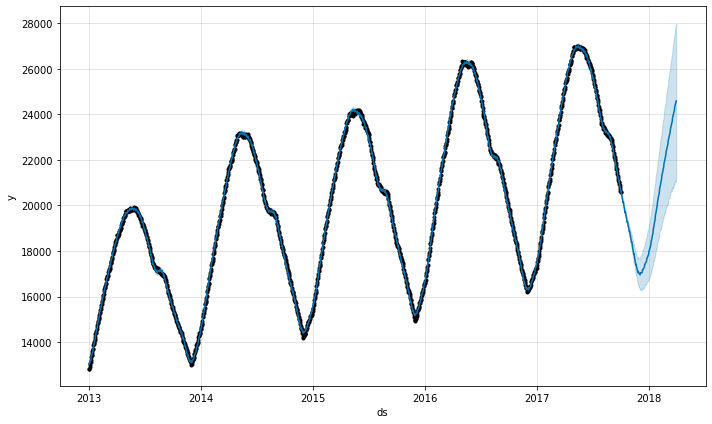

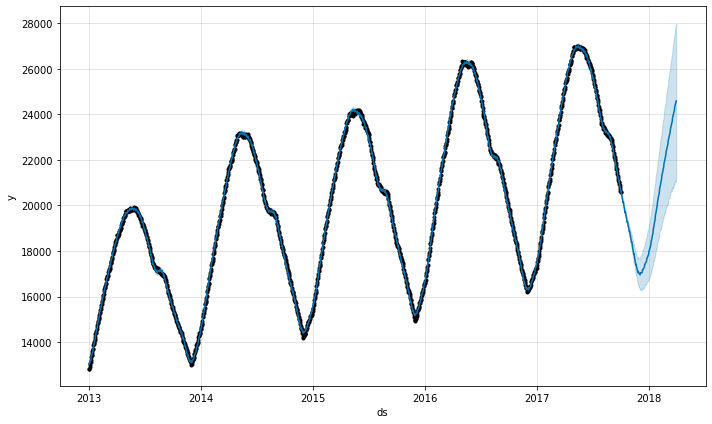

In [32]:
item_data, model, forecast = model_prediction('item_1', 180)
model.plot(forecast)

In [33]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds          yhat    yhat_lower    yhat_upper
0 2013-01-01  13041.045693  12911.066313  13165.880929
1 2013-01-02  13050.871572  12921.767341  13169.417431
2 2013-01-03  13090.547909  12973.424962  13217.560489
3 2013-01-04  13121.856206  13008.095651  13244.781630
4 2013-01-05  13152.589872  13027.988430  13282.035485

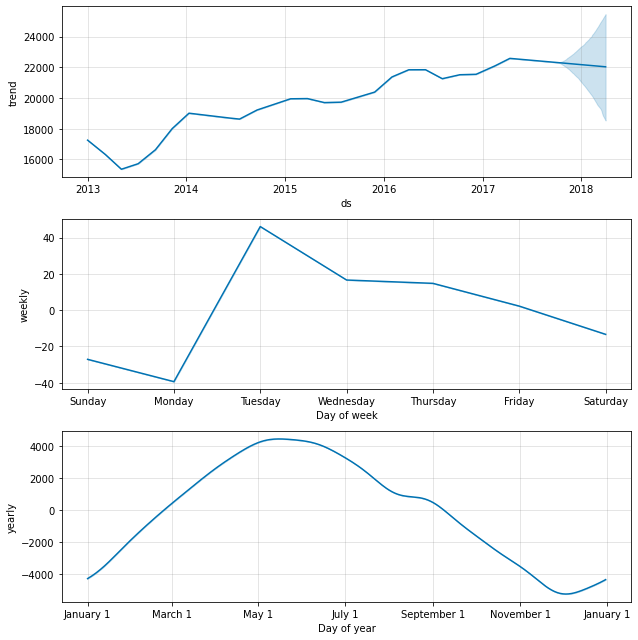

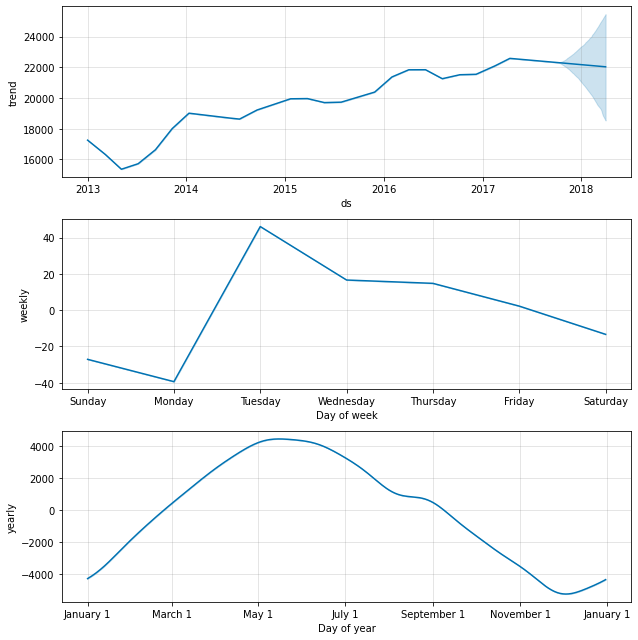

In [34]:
model.plot_components(forecast)

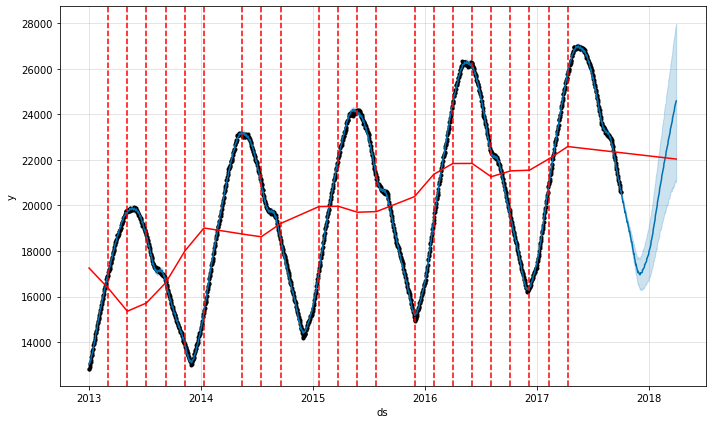

In [35]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [36]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '730 days',period = '180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-04-12 00:00:00 and 2016-10-03 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2015-04-13  23123.412370  23035.932579  23212.313378  23066.0 2015-04-12
1 2015-04-14  23255.040755  23169.933315  23349.460674  23206.0 2015-04-12
2 2015-04-15  23280.038769  23193.323757  23365.084346  23201.0 2015-04-12
3 2015-04-16  23327.850662  23242.504999  23419.202488  23226.0 2015-04-12
4 2015-04-17  23369.121585  23273.816921  23463.598446  23265.0 2015-04-12

In [37]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse        rmse         mae      mape     mdape  coverage
0 37 days  22484.687490  149.948950  118.623880  0.005827  0.004520  0.684932
1 38 days  23668.494353  153.845684  122.506864  0.006015  0.005081  0.688356
2 39 days  24974.711952  158.033895  126.486613  0.006202  0.005209  0.688356
3 40 days  26353.719230  162.338286  130.365504  0.006380  0.005791  0.691781
4 41 days  27688.292975  166.397996  134.131283  0.006556  0.005997  0.702055

# Train-test split

For the model validation, we shall split the date into train and test. By this way, we know the ground truth of the test data. We can validate and find the error related to it. Let test data be for 1 year.

In [38]:
def data(item_number):
  item_data = {"ds": [], "y": []}

  for i in range(len(df1)):
    if len(df1[i:i+90])==90:
      item_data["ds"].append(df1['date'][i])
      item_data["y"].append(df1[item_number][i:i+90].sum())
  item_data = pd.DataFrame(item_data)
  return item_data

In [39]:
# To get the actual aggregated sales value of all item from the previous function - Useful for validation later
def actual_sales(df1):
  actual_value = pd.DataFrame()
  for i in df1.columns[1:]:
    actual_value[str(i)] = data(i)['y'] # Function call - data(item_number)
  return actual_value

In [40]:
actual_sales = actual_sales(df1)

In [41]:
# Function for fitting the model for training dataset.

def model_fit(item_number):
  #Calling the dataframe for specific item
  item_data = data(item_number) #Function call - data(item_number)
  train, test = item_data[item_data['ds'] <= '2016-12-31'], item_data[item_data['ds'] > '2016-12-31']
  model = Prophet(interval_width = 0.80, changepoint_range = 0.9)
  #model = Prophet(changepoint_range=0.9)
  model.fit(train)

  return item_data, train, test, model

In [42]:
# Model prediction - Main function -> This includes data aggregation function and model fitting function.
def model_prediction(item_number, periods):
  # Calling model_fit function
  item_data, train, test, model = model_fit(item_number)
  future_dates = model.make_future_dataframe(periods = periods)
  forecast = model.predict(future_dates)
  return item_data, train, test, model, forecast

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


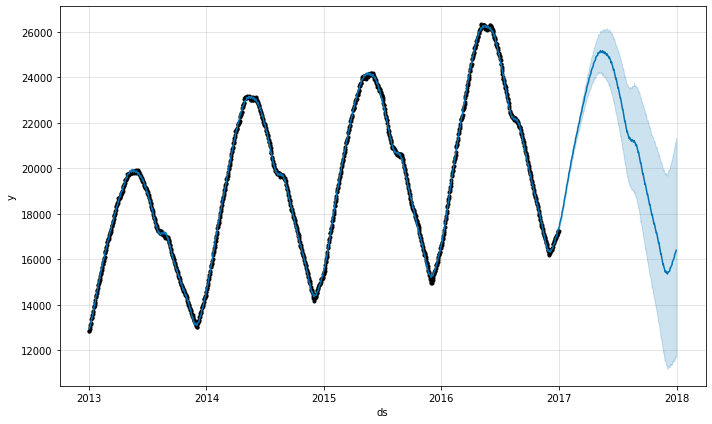

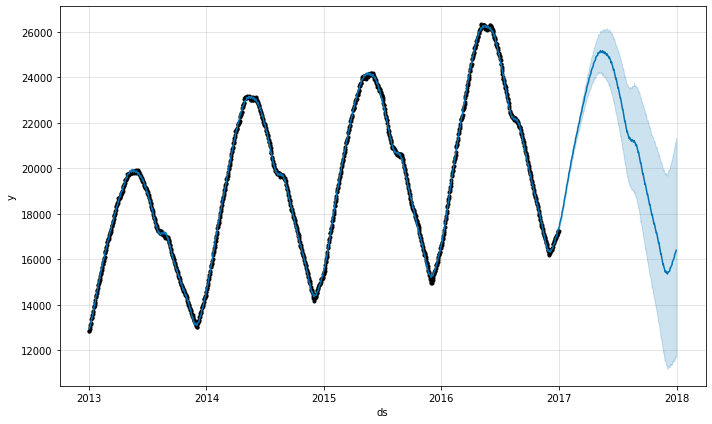

In [43]:
# Main function call which predicts the data from data aggregation, model fitting to training and predicton
item_data, train, test, model, forecast = model_prediction('item_1', 365)
model.plot(forecast)

In [44]:
len(df1) - (len(train) + len(test))

89

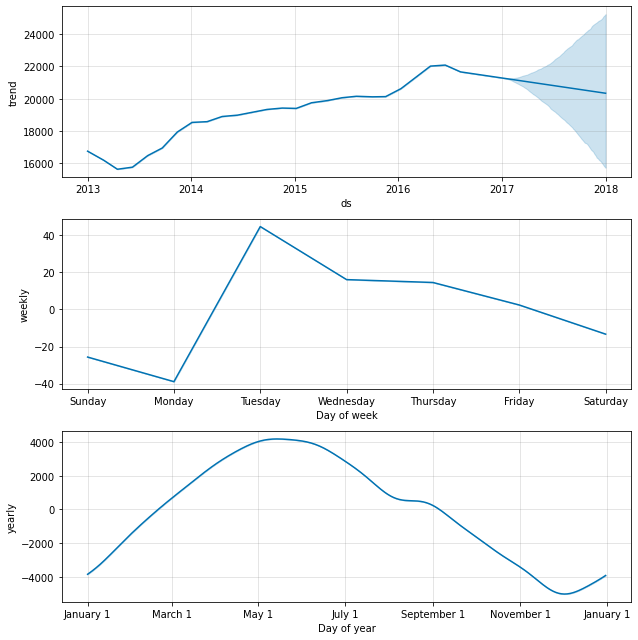

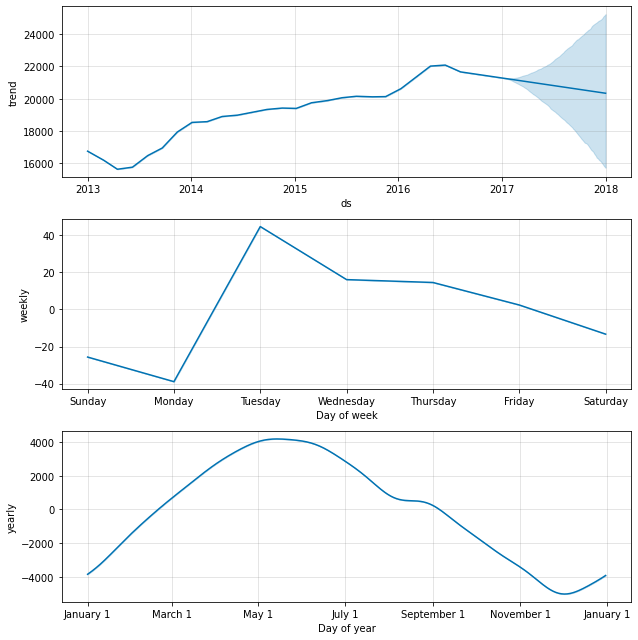

In [45]:
model.plot_components(forecast)

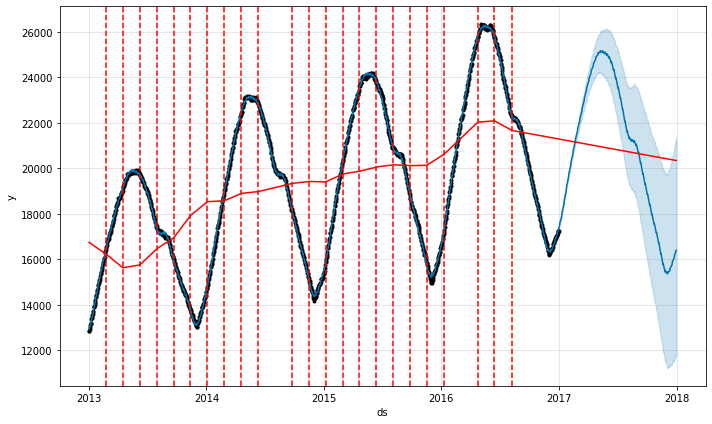

In [46]:
from fbprophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [47]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(model, forecast)
py.iplot(fig)

In [48]:
deltas = model.params['delta'].mean(0)
deltas

array([-9.90705225e-02,  7.75425838e-01,  6.14332764e-01, -2.38424812e-01,
        5.33239209e-01, -4.04556437e-01, -5.97396816e-01,  2.99468092e-01,
       -2.60783446e-01,  1.12184239e-01, -2.67873267e-03, -9.46573251e-02,
       -1.18323256e-01,  3.87303237e-01, -2.36116856e-01,  6.97964774e-02,
       -9.24550272e-02, -1.44057623e-01,  5.54372460e-02,  4.85463781e-01,
        2.44476934e-01,  1.01693391e-04, -6.78671364e-01, -5.06947244e-01,
        2.95864318e-01])

Changepoints plot

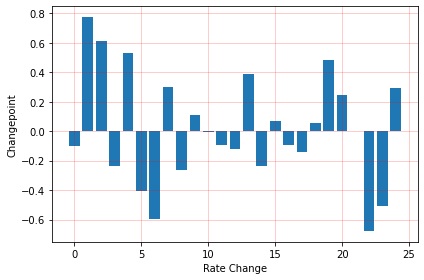

In [49]:
def plot_changepoint(deltas):
  fig = plt.figure(facecolor = 'w')
  ax = fig.add_subplot(111)
  ax.bar(range(len(deltas)), deltas)
  ax.grid(True, which = 'major', c = 'red', ls = '-', lw = 1, alpha = 0.2)
  ax.set_xlabel('Rate Change')
  ax.set_ylabel('Changepoint')
  fig.tight_layout()

plot_changepoint(deltas)

In [50]:
item_data.head()

ds        y
0  2013-01-01  12847.0
1  2013-01-02  12848.0
2  2013-01-03  12936.0
3  2013-01-04  13019.0
4  2013-01-05  13103.0

In [51]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial = '730 days',period = '180 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2015-04-11 00:00:00 and 2016-10-02 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2015-04-12  23086.472247  23028.186298  23145.512966  23051.0 2015-04-11
1 2015-04-13  23128.621167  23070.000941  23183.757976  23066.0 2015-04-11
2 2015-04-14  23260.816304  23205.903136  23320.208080  23206.0 2015-04-11
3 2015-04-15  23286.234521  23228.670408  23345.266379  23201.0 2015-04-11
4 2015-04-16  23334.795250  23279.828682  23394.823848  23226.0 2015-04-11

In [52]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse        rmse        mae      mape     mdape  coverage
0  9 days  10979.054459  104.780983  92.426058  0.004425  0.004187  0.333333
1 10 days  11811.316740  108.679882  93.885269  0.004533  0.004187  0.361111
2 11 days  12095.050122  109.977498  93.224727  0.004539  0.003894  0.416667
3 12 days  12550.556439  112.029266  92.354353  0.004547  0.003452  0.444444
4 13 days  13288.571682  115.276067  93.077046  0.004635  0.003217  0.500000

# Error

The forecast results in the predicted value represented as 'y_hat' in the dataframe. We shall compare the actual value 'y' from the train data to the predicted 'y_hat' value and find the error.

In [53]:
periods = 365

In [54]:
train_error = pd.DataFrame({'date': train.ds, 'y':train.y, 'y_hat': forecast[0:len(train)]['yhat']})
train_error.head()

date        y         y_hat
0  2013-01-01  12847.0  12949.167020
1  2013-01-02  12848.0  12970.497835
2  2013-01-03  12936.0  13020.691096
3  2013-01-04  13019.0  13062.144426
4  2013-01-05  13103.0  13101.942105

In [55]:
forecast[len(train):1737]['yhat']

1461    17412.762140
1462    17456.642815
1463    17599.250844
1464    17631.418986
1465    17692.582518
            ...     
1732    19080.713470
1733    19001.956672
1734    18926.383856
1735    18849.711575
1736    18869.745378
Name: yhat, Length: 276, dtype: float64

In [56]:
test_error = pd.DataFrame({'date': test.ds, 'y':test.y, 'y_hat': forecast[len(train):(len(train)+len(test))]['yhat']})
test_error

date        y         y_hat
1461  2017-01-01  17279.0  17412.762140
1462  2017-01-02  17368.0  17456.642815
1463  2017-01-03  17519.0  17599.250844
1464  2017-01-04  17574.0  17631.418986
1465  2017-01-05  17645.0  17692.582518
...          ...      ...           ...
1732  2017-09-29  20796.0  19080.713470
1733  2017-09-30  20704.0  19001.956672
1734  2017-10-01  20642.0  18926.383856
1735  2017-10-02  20578.0  18849.711575
1736  2017-10-03  20610.0  18869.745378

[276 rows x 3 columns]

1. MSE - Mean Squared error

Train and Test MSE

In [57]:
train_mse = np.mean(((train_error.y - train_error.y_hat)**2)/len(train))
print('Train_MSE: ',(train_mse))

Train_MSE:  2.557123476201196


In [58]:
test_mse = np.mean(((test_error.y - test_error.y_hat)**2)/len(test))
print('Train_MSE: ',(test_mse))

Train_MSE:  9317.59009479221


2. MAPE

MAPE refers to Mean Average Percentage Error which is the most commonly used Performance metric to measure forecast accuracy.

$MAPE = \frac{1}{n} \Sigma \frac{|e_t|}{d_t}$



Train MAPE

In [59]:
train_mape = np.mean(np.abs(train_error.y - train_error.y_hat)/train_error.y)*100
print('Train_MAPE: ',round(train_mape,3),'%')

Train_MAPE:  0.255 %


The Mean Averaged Percentage error of Train data for item 1 tells that the average difference between the forecasted value and the actual value is just 0.255% which is pretty good.

Test MAPE

In [60]:
test_mape = np.mean(np.abs(test_error.y - test_error.y_hat)/test_error.y)*100
print('Test_MAPE: ',round(test_mape,3),'%')

Test_MAPE:  6.02 %


The Mean Averaged Percentage error for the Test data for item 1 is at 6.02%

2. MSE - Mean Squared error

Train and Test MSE

In [61]:
train_mse = np.mean(((train_error.y - train_error.y_hat)**2)/len(train))
print('Train_MSE: ',(train_mse))

Train_MSE:  2.557123476201196


In [62]:
test_mse = np.mean(((test_error.y - test_error.y_hat)**2)/len(test))
print('Train_MSE: ',(test_mse))

Train_MSE:  9317.59009479221


# Evaluation for all items

The item evaluation is now done for a 3-month future prediction.

In [63]:
df1.columns[1:]

Index(['item_1', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7',
       'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13',
       'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19',
       'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25',
       'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31',
       'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37',
       'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43',
       'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49',
       'item_50'],
      dtype='object')

In [ ]:
all_item_prediction = pd.DataFrame()
for i in df1.columns[1:]:
  item_data, train, test, model, forecast = model_prediction(i, 366) #(366 - 276 = 90, 276-Length of test data)
  all_item_prediction[str(i)] = forecast['yhat']

In [65]:
all_item_prediction

item_1        item_2        item_3        item_4        item_5  \
0     12949.167020  34910.484859  21595.355840  13033.689446  10679.941633   
1     12970.497835  34948.203939  21631.409731  13058.982118  10699.644661   
2     13020.691096  35068.292668  21715.783897  13114.870908  10741.626122   
3     13062.144426  35154.696516  21783.537261  13158.410617  10776.713631   
4     13101.942105  35245.483669  21849.223871  13204.698612  10811.757168   
...            ...           ...           ...           ...           ...   
1822  16281.609156  41483.569247  27331.906406  14931.339200  13042.433693   
1823  16320.262915  41570.157428  27395.933836  14964.956059  13071.669217   
1824  16356.635250  41659.247567  27457.049487  15000.840737  13100.267209   
1825  16397.769558  41752.996629  27523.106821  15037.323696  13131.758652   
1826  16439.558088  41847.865019  27592.384098  15076.185992  13162.699955   

            item_6        item_7        item_8        item_9       item_10  \
0     34573.278888  34605.795608  45387.403037  30660.082957  43115.307298   
1     34630.923212  34665.613763  45462.733401  30708.061504  43188.705681   
2     34766.856261  34809.401588  45649.825999  30827.515427  43350.766043   
3     34872.874325  34921.283896  45793.247657  30919.488346  43482.676165   
4     34979.666638  35042.354317  45940.697095  31009.207100  43612.682450   
...            ...           ...           ...           ...           ...   
1822  40803.470793  42805.294394  56474.089056  39123.399868  53464.303222   
1823  40897.652185  42900.515533  56606.699849  39217.328692  53588.640583   
1824  40990.610550  43003.516296  56741.662699  39307.053399  53708.930059   
1825  41088.007027  43107.410982  56877.078874  39402.043726  53835.210291   
1826  41190.034293  43213.432055  57021.750811  39498.611727  53967.528448   

      ...       item_41       item_42       item_43       item_44  \
0     ...  12993.725078  21480.486186  30377.146971  17263.605819   
1     ...  13018.594550  21516.871619  30429.565536  17289.602690   
2     ...  13071.762513  21606.468193  30539.748292  17363.695155   
3     ...  13115.399633  21674.818042  30629.980297  17417.858532   
4     ...  13156.417648  21745.907416  30721.487175  17473.196837   
...   ...           ...           ...           ...           ...   
1822  ...  15661.644321  26143.399734  37815.335906  20315.353654   
1823  ...  15701.491865  26203.780702  37898.018903  20361.001599   
1824  ...  15738.238039  26265.797536  37980.275683  20407.086281   
1825  ...  15780.808594  26330.160499  38068.210041  20454.824603   
1826  ...  15821.517480  26393.990708  38154.134333  20504.370043   

           item_45       item_46       item_47       item_48       item_49  \
0     47459.924467  34846.689981  13051.830305  30227.860624  17242.198944   
1     47540.569774  34907.097991  13068.624661  30280.741942  17269.162836   
2     47728.481222  35047.085640  13114.695728  30398.600779  17334.370134   
3     47875.584747  35154.407347  13153.407003  30493.249496  17383.494600   
4     48020.535430  35259.720245  13192.366689  30584.996772  17436.868659   
...            ...           ...           ...           ...           ...   
1822  58208.273762  40087.897397  15954.511528  37341.924665  22166.862599   
1823  58340.787255  40166.442770  15988.947586  37426.669535  22214.991491   
1824  58468.852696  40241.097371  16023.125776  37506.797059  22266.275232   
1825  58608.925142  40330.929556  16054.800356  37600.776299  22318.363607   
1826  58752.464896  40416.658741  16093.140067  37686.785902  22370.998629   

           item_50  
0     38987.983764  
1     39049.912555  
2     39199.107061  
3     39317.755884  
4     39446.487962  
...            ...  
1822  46002.067587  
1823  46099.606386  
1824  46205.013389  
1825  46307.546387  
1826  46416.363541  

[1827 rows x 50 columns]

In [66]:
Final_forecast = pd.DataFrame(all_item_prediction.iloc[-1])
Final_forecast.head()

1826
item_1  16439.558088
item_2  41847.865019
item_3  27592.384098
item_4  15076.185992
item_5  13162.699955

# End of 90 day Sale prediction value

The below Sale prediction value represents the future 3 month prediction from the end of date in the training dataset.

In [ ]:
Three_month_future = pd.DataFrame({'item_number': Final_forecast.index[:], 'Sales': Final_forecast[1826][:].tolist()})
Three_month_future

In [68]:
# The prediction is saved in a CSV file
Three_month_future.to_csv('Three_month_sales_prediction.csv')

In [69]:
def actual_sales(df1):
  actual_value = pd.DataFrame()
  for i in df1.columns[1:]:
    actual_value[str(i)] = data(i)['y'] # Function call - data(item_number)
  return actual_value

In [77]:
actual_value = actual_sales(df1)

# Train and test metrics for all items

In [130]:
def train_mape(actual_value, all_item_prediction):
  train_mape = []
  test_mape = []
  for i in df1.columns[1:]:
    # train_mape
    train_mape.append(np.mean(np.abs((actual_value[i][0:len(train)] - all_item_prediction[i][0:len(train)])/actual_value[i][0:len(train)]))*100)
    #test mape
    x = actual_value[i][len(train):(len(train)+len(test))]
    y = all_item_prediction[i][len(train):(len(train)+len(test))]
    test_mape.append(np.mean(np.abs((x-y)/x)*100))
  return train_mape, test_mape

In [131]:
all_train_mape, all_test_mape = train_mape(actual_value, all_item_prediction)

In [134]:
Three_month_future['train_mape'] = all_train_mape
Three_month_future['test_mape'] = all_test_mape

In [135]:
Three_month_future

item_number         Sales  train_mape  test_mape
0       item_1  16439.558088    0.254613   6.019959
1       item_2  41847.865019    0.200788   7.915846
2       item_3  27592.384098    0.233428   5.827478
3       item_4  15076.185992    0.228991   9.204364
4       item_5  13162.699955    0.286290   7.964168
5       item_6  41190.034293    0.209228   7.840263
6       item_7  43213.432055    0.204672   6.665241
7       item_8  57021.750811    0.204480   6.749041
8       item_9  39498.611727    0.207892   4.632033
9      item_10  53967.528448    0.193499   7.121374
10     item_11  48697.436786    0.210705   8.646085
11     item_12  49425.083327    0.221521   7.776871
12     item_13  60569.438235    0.186408   7.868438
13     item_14  41762.032416    0.220462   7.786818
14     item_15  65045.172538    0.220951   6.836875
15     item_16  20105.162941    0.240098   3.920844
16     item_17  23618.638863    0.240609   7.110976
17     item_18  61408.324238    0.223578   7.123939
18     item_19  29940.054894    0.237654   6.229444
19     item_20  35888.865687    0.207776   5.885135
20     item_21  29832.436769    0.235642   6.716725
21     item_22  58186.156939    0.198533   7.221738
22     item_23  20658.624865    0.215338   8.784396
23     item_24  47854.786012    0.205439   7.170404
24     item_25  55974.591732    0.203422   8.982545
25     item_26  35891.277551    0.207404   6.088060
26     item_27  15548.269027    0.249560   8.187585
27     item_28  64888.521165    0.195007   6.710636
28     item_29  51670.991225    0.207608   6.234428
29     item_30  29147.420066    0.231570   7.884648
30     item_31  44369.191869    0.204268   5.604557
31     item_32  31603.213623    0.237866   7.973239
32     item_33  50615.763763    0.220076   7.391098
33     item_34  18986.771864    0.249798   7.257425
34     item_35  49454.980839    0.210866   5.877531
35     item_36  53239.463947    0.209568   8.682789
36     item_37  21431.792929    0.218788   7.533965
37     item_38  58247.738019    0.193917   7.222774
38     item_39  33039.038224    0.227420   5.993832
39     item_40  20324.881324    0.237544   8.718470
40     item_41  15821.517480    0.269839   7.881605
41     item_42  26393.990708    0.231415   7.269975
42     item_43  38154.134333    0.216229   6.835761
43     item_44  20504.370043    0.217344   8.530293
44     item_45  58752.464896    0.201171   7.415652
45     item_46  40416.658741    0.211476   9.256136
46     item_47  16093.140067    0.243410   7.232996
47     item_48  37686.785902    0.220040   6.695990
48     item_49  22370.998629    0.239607   5.895143
49     item_50  46416.363541    0.223590   8.337094